In [16]:
# https://mail.google.com/mail/u/0/#inbox/QgrcJHrnscJGjsRzFLPzmGMZSlGWKMsntRB

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from childes_mi.utils.paths import DATA_DIR, ensure_dir, DROSOPHILA_DIR
import urllib.request

In [19]:
from tqdm.autonotebook import tqdm
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
mat_file = list(DROSOPHILA_DIR.glob('*.mat'))[0]
mat_file

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/childes_mi_project/data/raw/DROSOPHILA_Data_Dir/transition_data.mat')

In [21]:
ds = scipy.io.loadmat(mat_file.as_posix())

In [22]:
ds.keys()

dict_keys(['__header__', '__version__', '__globals__', 'density', 'transition_states', 'xx', 'peakPoints', 'regionMap'])

In [23]:
ds['transition_states'][0]

array([array([[59],
       [43],
       [11],
       ...,
       [43],
       [40],
       [44]], dtype=uint8)], dtype=object)

In [24]:
states = [np.concatenate(np.concatenate(i)) for i in ds['transition_states']]

In [25]:
states[0]

array([59, 43, 11, ..., 43, 40, 44], dtype=uint8)

In [26]:
len(states[0])

10803

In [27]:
state_lens = [len(i) for i in states]

(array([ 3.,  1.,  6.,  8., 18., 11.,  8.,  3.,  0.,  1.]),
 array([ 7447. ,  8181.3,  8915.6,  9649.9, 10384.2, 11118.5, 11852.8,
        12587.1, 13321.4, 14055.7, 14790. ]),
 <a list of 10 Patch objects>)

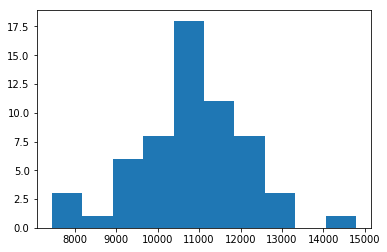

In [28]:
plt.hist(state_lens)

In [29]:
bouts_indv = [["{}_{}".format(bi, element) for element in bout] for bi, bout in enumerate(tqdm(states))]

### Mutual information

In [30]:
from childes_mi.information_theory import mutual_information as mi

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.supervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.expected_mutual_info_fast module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [31]:
distances = np.arange(1,1001)

In [32]:
(MI, MI_var), (shuff_MI, shuff_MI_var) = mi.sequential_mutual_information(
    [np.random.permutation(i) for i in bouts_indv], distances=distances, n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   22.9s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.9s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 818 tasks      | elapsed:   20.7s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.9s finished


In [33]:
MI_DF = pd.DataFrame(
    [[MI, MI_var, shuff_MI, shuff_MI_var, distances]],
    columns=["MI", "MI_var", "shuff_MI", "shuff_MI_var", "distances"],
)

In [34]:
MI_DF.to_pickle(DATA_DIR / "mi" / "drosophila_mi_1000_shuffled.pickle")

In [35]:
row = MI_DF.iloc[0]

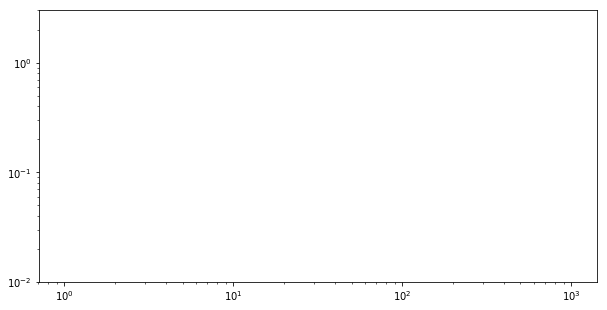

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
MI = row.MI-row.shuff_MI
MI_var = row.MI_var

ax.scatter(distances, MI)
ax.fill_between(distances, MI-MI_var, MI+MI_var, alpha = 0.25, color= 'k')
ax.set_ylim([1e-2, 3])
ax.set_yscale('log')
ax.set_xscale('log')

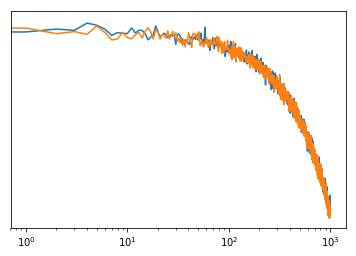

In [37]:
plt.loglog(row.MI)
plt.loglog(row.shuff_MI)

In [40]:
from matplotlib import gridspec

In [41]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten,save_fig

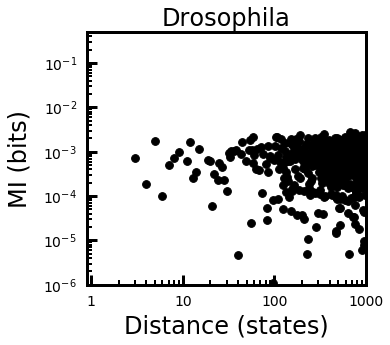

In [42]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF)*zoom*1.0,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF), nrows=4, height_ratios=hr) 

axi = 0
row = MI_DF.iloc[0]

color = 'k'#LCOL_DICT[row.language]
ax0 = plt.subplot(gs[0,axi])
ax = ax0
sig = np.array(row.MI-row.shuff_MI)
distances = row.distances
sig = sig
# get signal limits
sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]

if axi==0: 
        ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
        ax.yaxis.set_label_coords(yoff,0.5)

# plot real data
ax.scatter(distances, sig, alpha = 1, s=60, color=color)   

ax.set_xlabel('Distance (states)', labelpad=5, fontsize=24)
#print(row.language, distances[peak_of_interest])

for ax in [ax0]:
    ax.set_xlim([distances[0], distances[-1]])
    sig_lims[0] = np.log(10e-6)
    ax.set_ylim([1e-6, 0.5])
    ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
    ax.tick_params(which='major', length=10, width =3)
    ax.tick_params(which='minor', length=5, width =2)
    ax.set_xscale( "log" , basex=10)
    ax.set_yscale( "log" , basey=10)
    ax.set_xticks([])
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
        ax.spines[axis].set_color('k')

ax.set_xticks([1,10,100, 1000])
ax.set_xticklabels(['1','10','100', '1000'])
ax.set_xlim([0.9, 1000])
if axi !=0:
    for ax in [ax0,ax1,ax2]:
        ax.yaxis.set_ticklabels([])

gs.update(wspace=0.075, hspace=0.1)
ax0.set_title("Drosophila", fontsize=24)
save_fig(FIGURE_DIR/'drosophila_mi-1000-shuffled')